# Reading data and initializing

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix

spark=SparkSession.builder \
.master ("local[*]")\
.appName("part3")\
.getOrCreate()

sc=spark.sparkContext
sqlContext=SQLContext(sc)

C:\Apps\spark-3.3.0-bin-hadoop3\python\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
# read in the dataframe for the assignment
df=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .option("sep",";")\
 .csv("C:/Users/quoej/OneDrive/Desktop/MS BAnDS OSU/Fall 2022 - BAN 5753 Advanced Business Analytics/MiniProject/XYZ_Bank_Deposit_Data_Classification.csv")
print("There are",df.count(),"rows",len(df.columns),
      "columns" ,"in the data.")

There are 41188 rows 21 columns in the data.


In [4]:
df = df.withColumnRenamed("emp.var.rate", "emp_var_rate")
df = df.withColumnRenamed("cons.price.idx", "cons_price_idx")
df = df.withColumnRenamed("cons.conf.idx", "cons_conf_idx")
df = df.withColumnRenamed("nr.employed", "nr_employed")

# Data Exploration

In [5]:
df.show(5)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 57| services|married|high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 37| serv

In [6]:
df.summary().toPandas().transpose()

,0,1,2,3,4,5,6,7
summary,count,mean,stddev,min,25%,50%,75%,max
age,41188,40.02406040594348,10.421249980934043,17,32,38,47,98
job,41188,None,None,admin.,None,None,None,unknown
marital,41188,None,None,divorced,None,None,None,unknown
education,41188,None,None,basic.4y,None,None,None,unknown
default,41188,None,None,no,None,None,None,yes
housing,41188,None,None,no,None,None,None,yes
loan,41188,None,None,no,None,None,None,yes
contact,41188,None,None,cellular,None,None,None,telephone
month,41188,None,None,apr,None,None,None,sep


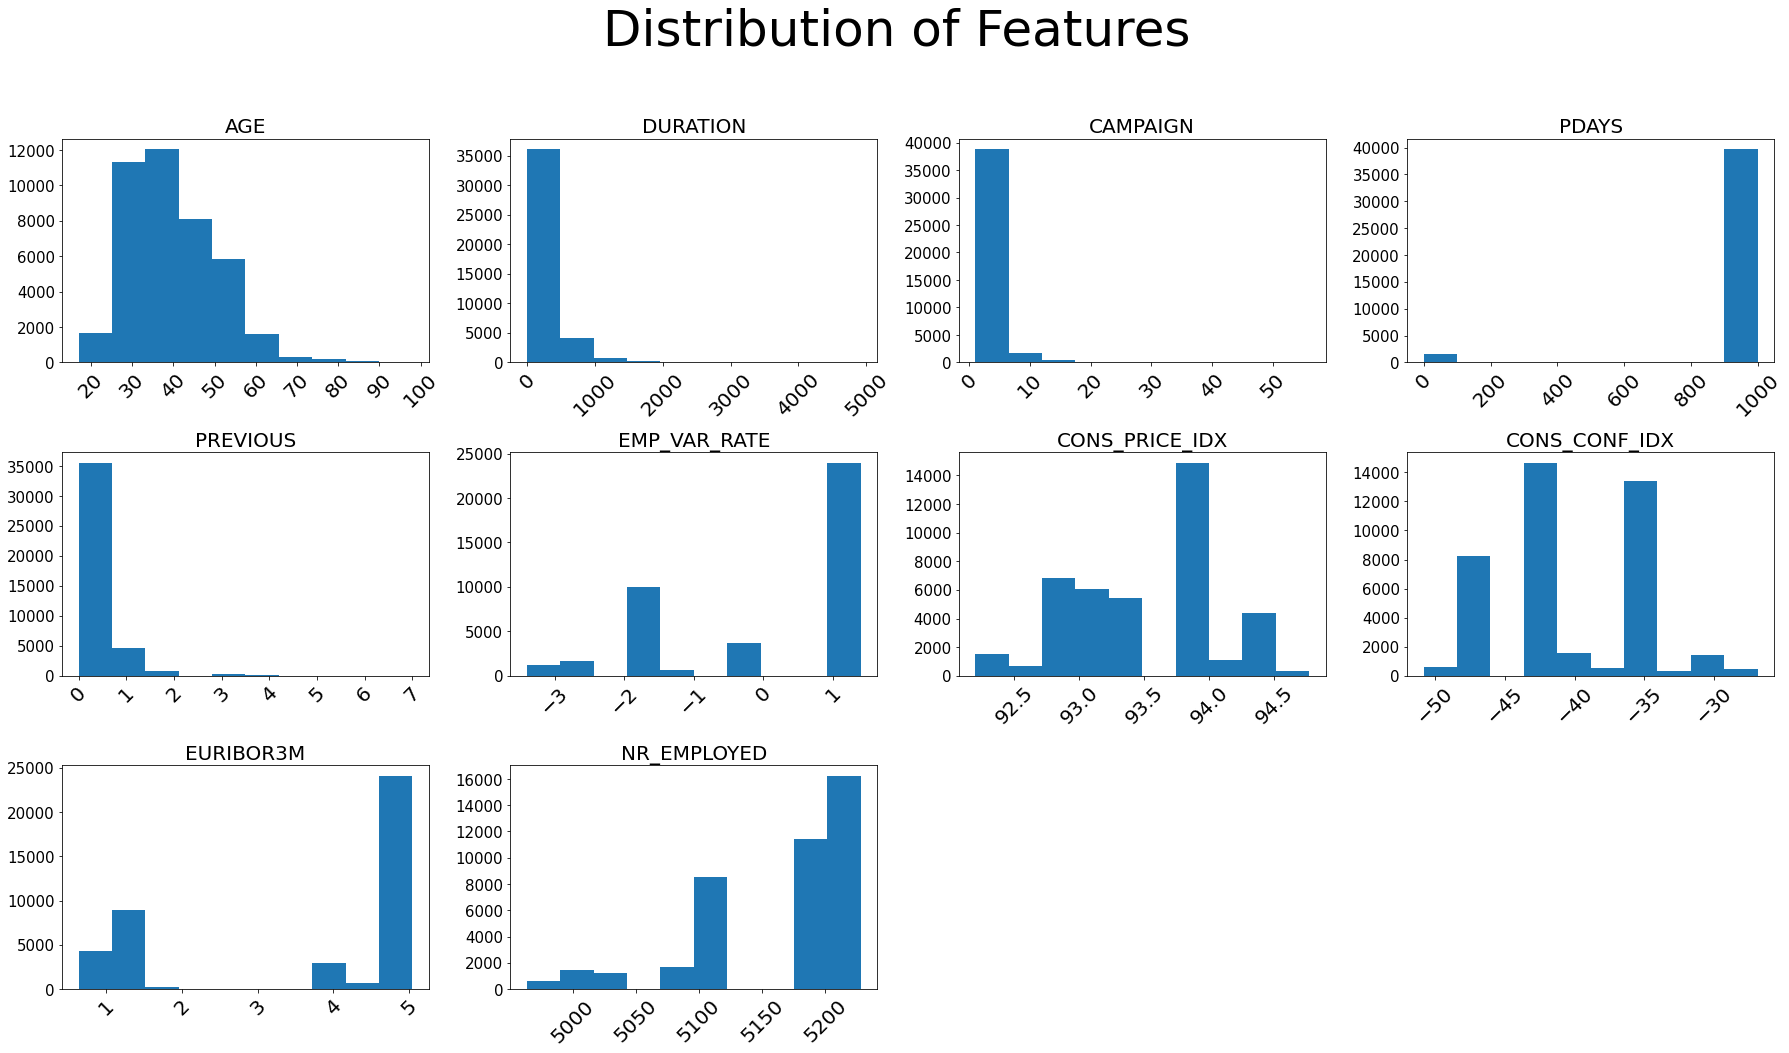

In [7]:
from matplotlib import cm
fig = plt.figure(figsize=(25,15)) ## Plot Size 
st = fig.suptitle("Distribution of Features", fontsize=50,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(df.toPandas().describe().columns, range(1,11)):
    ax = fig.add_subplot(3,4,num)
    ax.hist(df.toPandas()[col])
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

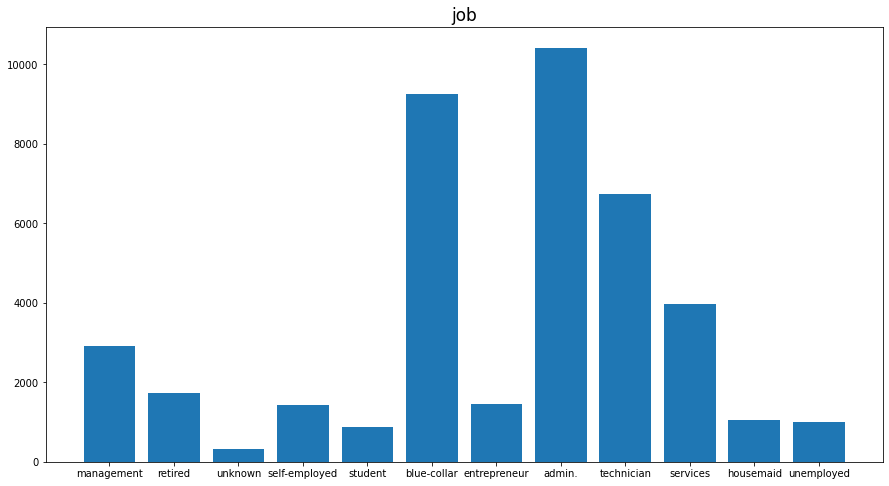

None

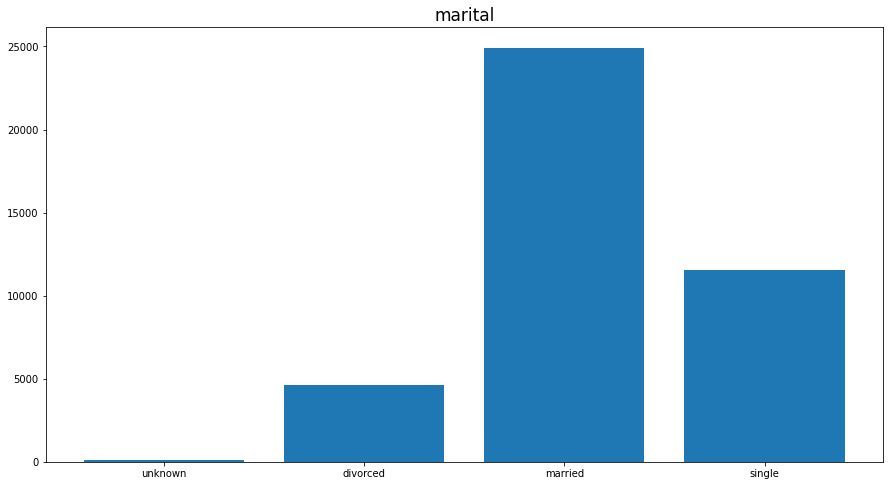

None

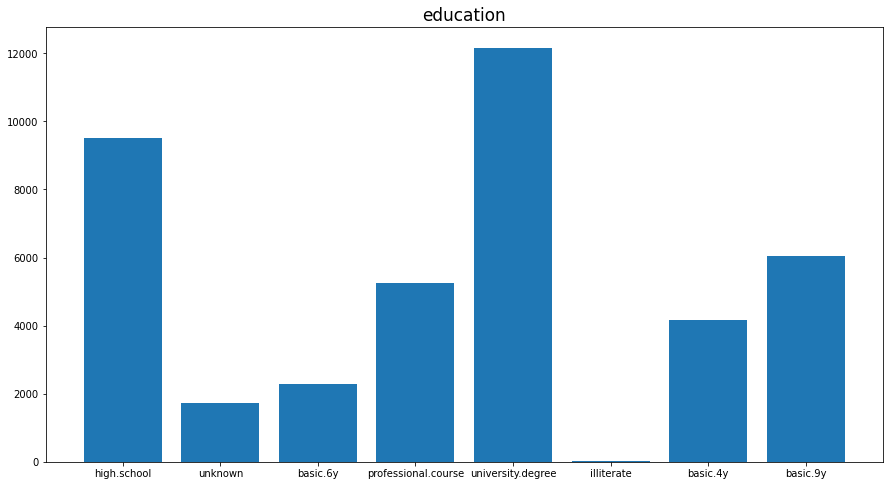

None

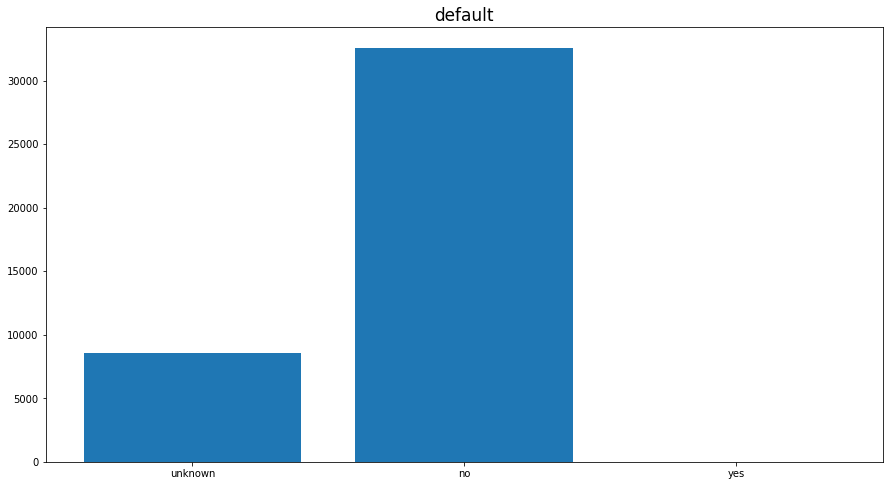

None

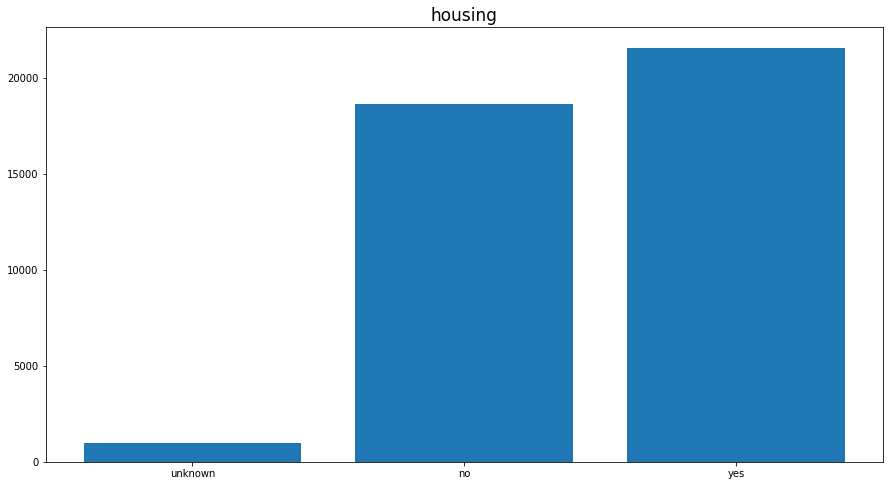

None

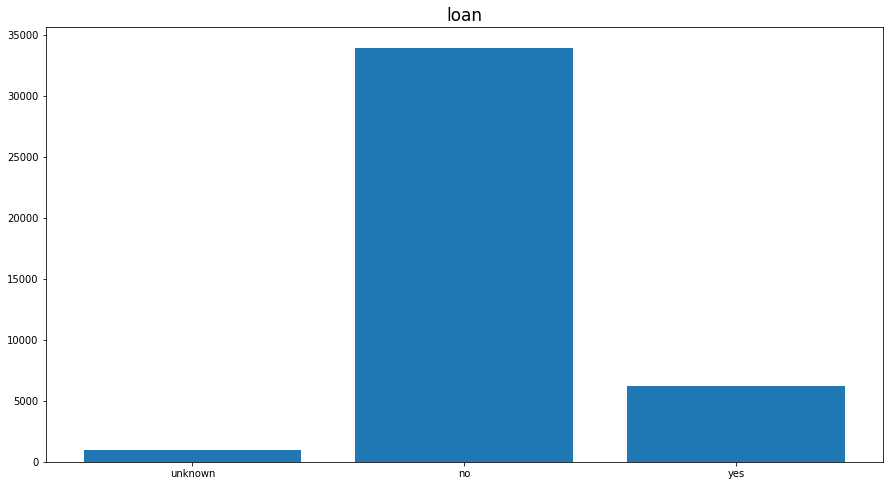

None

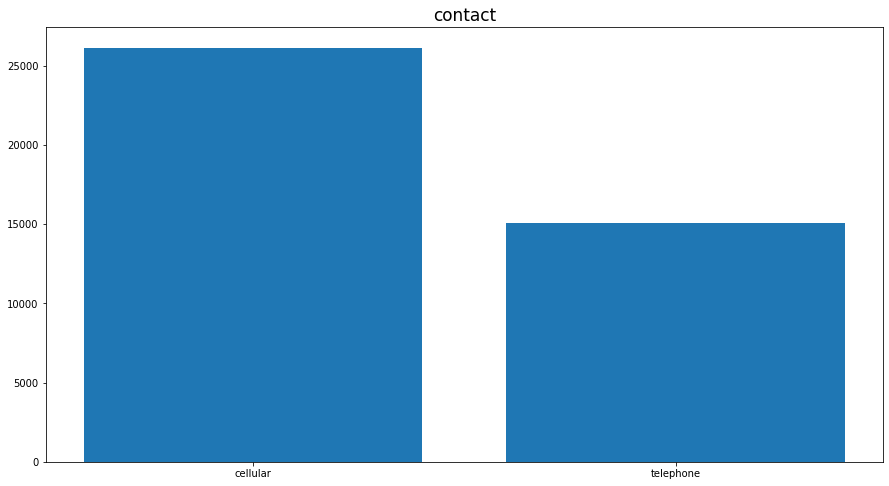

None

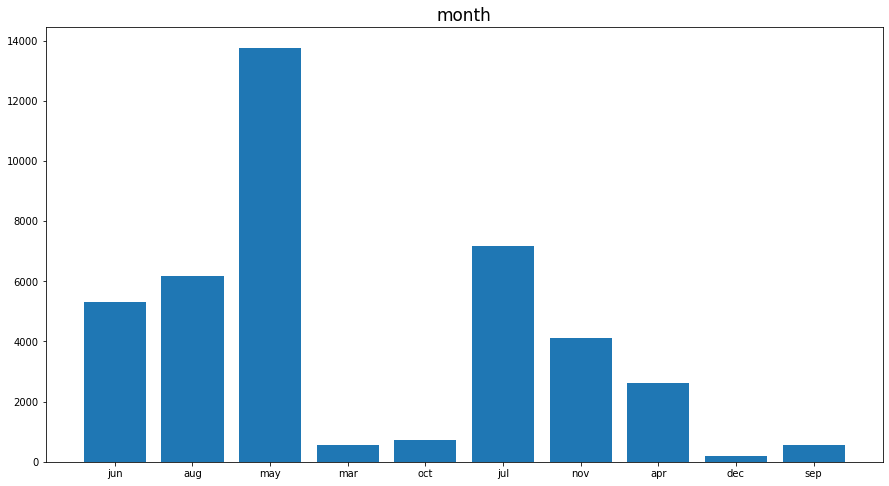

None

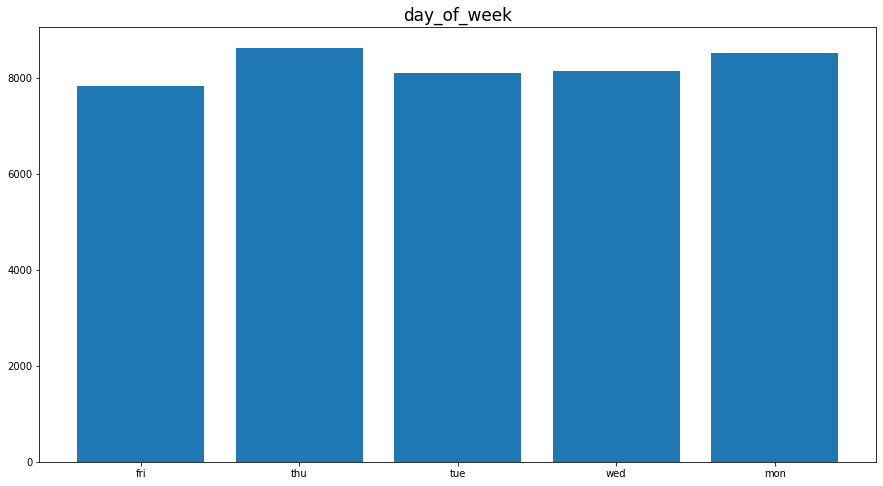

None

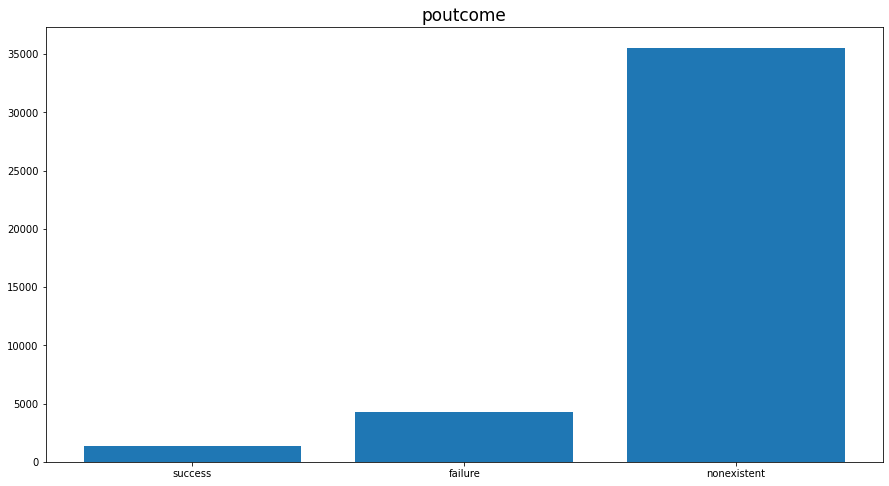

None

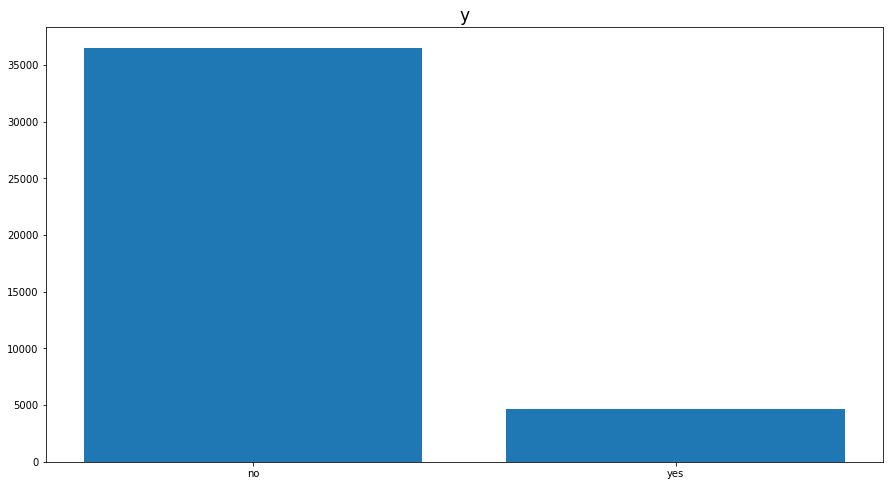

None

In [118]:
df.createOrReplaceTempView("DF")
for i in string_features:
    plt.figure(figsize=(15,8))
    new = spark.sql("select " + i + ", count(" + i + ") from DF group by " + i).toPandas()
    plt.bar(new.iloc[:,0], new.iloc[:,1])
    plt.title(i, fontdict={'fontsize': 17})
    display(plt.show())

In [8]:
# Null values for the dataset
{col:df.filter(df[col].isNull()).count() for col in df.columns}

{'age': 0,
 'job': 0,
 'marital': 0,
 'education': 0,
 'default': 0,
 'housing': 0,
 'loan': 0,
 'contact': 0,
 'month': 0,
 'day_of_week': 0,
 'duration': 0,
 'campaign': 0,
 'pdays': 0,
 'previous': 0,
 'poutcome': 0,
 'emp_var_rate': 0,
 'cons_price_idx': 0,
 'cons_conf_idx': 0,
 'euribor3m': 0,
 'nr_employed': 0,
 'y': 0}

In [9]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)



In [10]:
# total numeric variables
numeric_features = [t[0] for t in df.dtypes if t[1] != 'string']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,41188,40.02406040594348,10.421249980934043,17,98
duration,41188,258.2850101971448,259.27924883646455,0,4918
campaign,41188,2.567592502670681,2.770013542902331,1,56
pdays,41188,962.4754540157328,186.910907344741,0,999
previous,41188,0.17296299893172767,0.49490107983928927,0,7
emp_var_rate,41188,0.08188550063178966,1.57095974051703,-3.4,1.4
cons_price_idx,41188,93.5756643682899,0.5788400489540823,92.201,94.767
cons_conf_idx,41188,-40.502600271918276,4.628197856174573,-50.8,-26.9
euribor3m,41188,3.621290812858533,1.7344474048512595,0.634,5.045


In [11]:
# total string variables
string_features = [t[0] for t in df.dtypes if t[1] == 'string']

In [12]:
# cardinality for the categorical variables
from pyspark.sql.functions import countDistinct
cardinality = [countDistinct(c).alias(c) for c in string_features]
df.select(cardinality).show()

+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+---+
|job|marital|education|default|housing|loan|contact|month|day_of_week|poutcome|  y|
+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+---+
| 12|      4|        8|      3|      3|   3|      2|   10|          5|       3|  2|
+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+---+



In [13]:
for i in string_features:
    df.select(i).distinct().show()

+-------------+
|          job|
+-------------+
|   management|
|      retired|
|      unknown|
|self-employed|
|      student|
|  blue-collar|
| entrepreneur|
|       admin.|
|   technician|
|     services|
|    housemaid|
|   unemployed|
+-------------+

+--------+
| marital|
+--------+
| unknown|
|divorced|
| married|
|  single|
+--------+

+-------------------+
|          education|
+-------------------+
|        high.school|
|            unknown|
|           basic.6y|
|professional.course|
|  university.degree|
|         illiterate|
|           basic.4y|
|           basic.9y|
+-------------------+

+-------+
|default|
+-------+
|unknown|
|     no|
|    yes|
+-------+

+-------+
|housing|
+-------+
|unknown|
|     no|
|    yes|
+-------+

+-------+
|   loan|
+-------+
|unknown|
|     no|
|    yes|
+-------+

+---------+
|  contact|
+---------+
| cellular|
|telephone|
+---------+

+-----+
|month|
+-----+
|  jun|
|  aug|
|  may|
|  mar|
|  oct|
|  jul|
|  nov|
|  apr|
|  dec|
|  sep|

In [14]:
# correlations of variables
# putting the features together
numeric_features = [t[0] for t in df.dtypes if t[1] != 'string']
numeric_features_df=df.select(numeric_features)
numeric_features_df.toPandas().head()

# numeric feature correlations
col_names = numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])
corr_mat = Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

corr_df

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
emp_var_rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
cons_price_idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
cons_conf_idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
nr_employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


# Data split

In [15]:
# split the preprocessed data into training and split datasets
df1 = df
train, test = df1.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 32894
Test Dataset Count: 8294


# Pre-processing and feature engineering

In [16]:
# For the string features
stages = []
for col in string_features[:-1]:
    stringIndexer = StringIndexer(inputCol=col, outputCol=col + 'coded')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[col + "classVec"])
    stages += [stringIndexer, encoder]

# for the outcome label
label_string = StringIndexer(inputCol= 'y', outputCol='label')
stages += [label_string]

# for the numerical columns as well
assemblerInputs = [c + 'classVec' for c in string_features[:-1]] + numeric_features
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol='vectorized_features', handleInvalid='skip')
stages += [assembler]

# scale down the features into something usable
scaler = StandardScaler(inputCol='vectorized_features', outputCol='features')
stages += [scaler]

In [17]:
cols = train.columns
pipeline = Pipeline(stages=stages)
pipelinemodel = pipeline.fit(train)
train = pipelinemodel.transform(train)
selectedCols = ['label', 'features'] + cols
train_set = train.select(selectedCols)

In [18]:
cols = test.columns
test = pipelinemodel.transform(test)
selectedCols = ['label', 'features'] + cols
test_set = test.select(selectedCols)

# Logistic Regression

In [19]:
# training for the logistic regression
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=5)
lrModel = lr.fit(train_set)
predictions = lrModel.transform(test_set)
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.432817293978493, -3.432817293978493]",0.0,"[0.9687145633581413, 0.03128543664185868]"
1,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.889522232450858, -1.889522232450858]",0.0,"[0.8687010462139406, 0.13129895378605938]"
2,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.5032090205026307, -0.5032090205026307]",0.0,"[0.6232131660477247, 0.3767868339522753]"
3,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.720533349742409, -1.720533349742409]",0.0,"[0.8481975224024905, 0.15180247759750953]"
4,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.049335224750765, -2.049335224750765]",0.0,"[0.8858804296442255, 0.11411957035577447]"


In [20]:
# confusion matrix
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 400  542]
 [ 182 7170]]


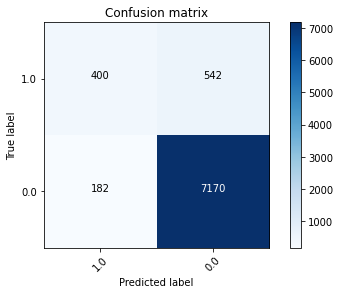

In [21]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [22]:
# model accuracy
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.9127079816734989


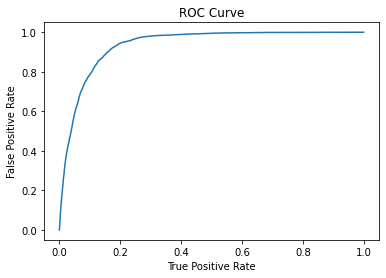

Training set area under ROC: 0.9347058264425107


In [23]:
# training ROC for the model
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set area under ROC: ' + str(trainingSummary.areaUnderROC))

In [24]:
# testing ROC for model
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9385618599095726


# Decision Tree

In [25]:
from pyspark.ml.classification import DecisionTreeClassifier
dtc = DecisionTreeClassifier(featuresCol="features", labelCol="label", )
dtcModel = dtc.fit(train_set)

predictions = dtcModel.transform(test_set)
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[22390.0, 166.0]",0.0,"[0.9926405391026778, 0.00735946089732222]"
1,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1475.0, 250.0]",0.0,"[0.855072463768116, 0.14492753623188406]"
2,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1475.0, 250.0]",0.0,"[0.855072463768116, 0.14492753623188406]"
3,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1475.0, 250.0]",0.0,"[0.855072463768116, 0.14492753623188406]"
4,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1475.0, 250.0]",0.0,"[0.855072463768116, 0.14492753623188406]"


In [26]:
# confusion matrix
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 517  425]
 [ 254 7098]]


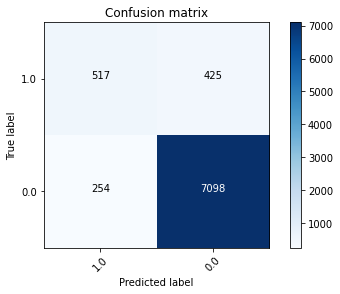

In [27]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [28]:
# model accuracy
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.9181335905473836


C:\Apps\spark-3.3.0-bin-hadoop3\python\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Testing Area Under ROC: 0.9246932099877786


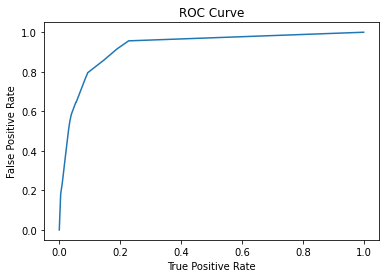

In [29]:
import matplotlib.pyplot as plt
from pyspark.mllib.evaluation import BinaryClassificationMetrics
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('ROC Curve')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.plot(x_val, y_val)
print("Testing Area Under ROC: " + str(CurveMetrics(preds).areaUnderROC))

In [ ]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9186986974672451


# Random Forest

In [31]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train_set)
predictions = rfModel.transform(test_set)
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[19.106818153806927, 0.893181846193077]",0.0,"[0.9553409076903462, 0.04465909230965384]"
1,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[17.80799101201482, 2.19200898798518]",0.0,"[0.890399550600741, 0.10960044939925899]"
2,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[17.588508070138044, 2.411491929861958]",0.0,"[0.8794254035069022, 0.1205745964930979]"
3,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[17.74460487149001, 2.255395128509987]",0.0,"[0.8872302435745005, 0.11276975642549936]"
4,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[17.80799101201482, 2.19200898798518]",0.0,"[0.890399550600741, 0.10960044939925899]"


In [32]:
# confusion matrix
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 161  781]
 [  33 7319]]


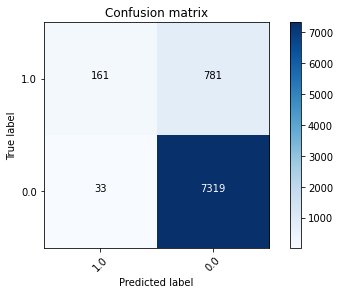

In [33]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [35]:
# model accuracy
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.9018567639257294


C:\Apps\spark-3.3.0-bin-hadoop3\python\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Testing Area Under ROC: 0.918698697467245


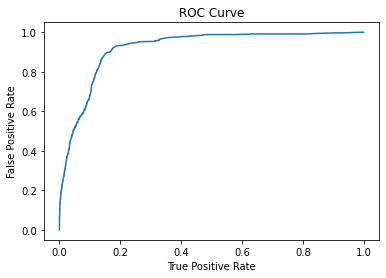

In [36]:
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('ROC Curve')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.plot(x_val, y_val)
print("Testing Area Under ROC: " + str(CurveMetrics(preds).areaUnderROC))

In [34]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9186986974672451


# Gradient Boosting Classifier

In [37]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train_set)
predictions = gbtModel.transform(test_set)
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.2993270627600926, -1.2993270627600926]",0.0,"[0.9307749112195316, 0.0692250887804684]"
1,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.846359901331813, -0.846359901331813]",0.0,"[0.8445815056089562, 0.15541849439104383]"
2,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.8118120764680374, -0.8118120764680374]",0.0,"[0.8352943385295638, 0.1647056614704362]"
3,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.846359901331813, -0.846359901331813]",0.0,"[0.8445815056089562, 0.15541849439104383]"
4,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.1068367219093098, -1.1068367219093098]",0.0,"[0.9014706883612107, 0.09852931163878931]"


In [38]:
# confusion matrix
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 501  441]
 [ 242 7110]]


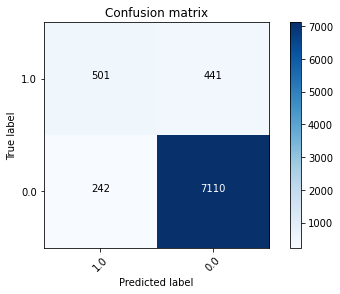

In [39]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [40]:
# model accuracy
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.9176513142030384


C:\Apps\spark-3.3.0-bin-hadoop3\python\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Testing Area Under ROC: 0.9474143985546926


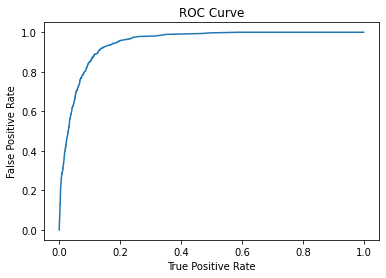

In [41]:
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('ROC Curve')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.plot(x_val, y_val)
print("Testing Area Under ROC: " + str(CurveMetrics(preds).areaUnderROC))

In [42]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9474143985546924


# K Means

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='features', k=i)
    
    KMeans_fit=KMeans_algo.fit(train_set)
    
    output=KMeans_fit.transform(train_set)
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.2132094975710437
Silhouette Score: 0.06861516804476887
Silhouette Score: 0.19504702377295433
Silhouette Score: 0.09671444760156812
Silhouette Score: 0.09604820027221483
Silhouette Score: 0.11111718949910832
Silhouette Score: 0.1078767305566322
Silhouette Score: 0.11760659812045579


Text(0, 0.5, 'cost')

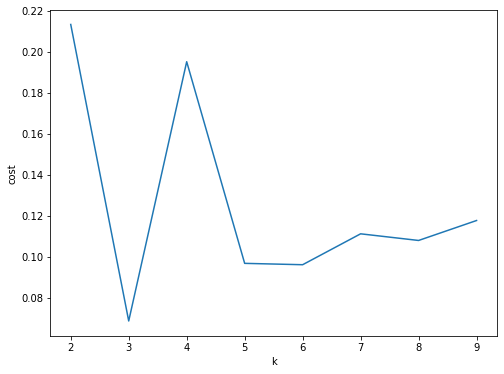

In [ ]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')